# DQN

This is an implementation of Deep Q-Network algorithm.
Q-learning is a value-based off-policy temporal difference(TD) reinforcement learning algorithm.
Deep Q-Network is a Q-learning algorithm with value function approximation using a deep neural network.

$Q_w: \mathbb{R}^n \rightarrow \mathbb{R}^m$, where $n$ is state space dimension and $m$ is action space dimension

Normal Q learning update is defined with the following expression that can be derived from the Bellman's optimality equation:
$$
Q^{k+1}(s_t, a_t) \leftarrow Q^k(s_t, a_t) + \alpha*(R_{t+1} + \gamma * \max_{a_{t+1}} Q^k(s_{t+1}, a_{t+1}) - Q^k(s_t, a_t))
$$
Note that updates are done by following a greedy target policy $pi(a|s)=I_{\{a=\arg\max_{a}{Q(s, a)}\}}$, whereas the behavioral policy $\mu$ is $e$-greedy with slowly decaying $e$ value. This allows GLIE (greedy in limit with inifinite exploration) which is known to converge in tabular case.

With approximate value estimators $Q_w$ we want to minimize the difference between the one-step "greedified" bootstrap target $\hat{T_t}=R_{t+1} + \gamma * \max_{a_{t+1}} Q_w^k(s_{t+1}, a_{t+1})$ and the current value estimation $Q_w^k(s_t, a_t)$

This can be done by introducing MSE pseudo-loss function:

$$
\mathcal{L}(\hat{T_t}, Q_t) = (R_{t+1} + [[\gamma * \max_{a_{t+1}} Q_w^k(s_{t+1}, a_{t+1})]] - Q_w^k(s_t, a_t))^2
$$

Where double brackets "guard" a part that shouldn't be differentiated.

$$
\nabla_w{\mathcal{L}(\hat{T_t}, Q_t)} \propto R_{t+1} + \gamma * \max_{a_{t+1}} Q_w^k(s_{t+1}, a_{t+1}) - \nabla_w{Q_w^k(s_t, a_t)}\\
$$

This gives us parameter updates:
$$
\bold{w} = \bold{w} - \alpha * \nabla_w{\mathcal{L}(\hat{T_t}, Q_t)}
$$

Additionally, a replay buffer is used in this implementation to decorrelate subsequent state-action traces.

## Links

- [2013 Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)

In [1]:
import random

import gym
import numpy as np
import torch
import itertools

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

MAX_BUFFER = 100000

In [2]:
class DQNModel(torch.nn.Module):

    def __init__(self, states_size, actions_size, hidden_num, hidden_layers=0):
        super().__init__()
        layers = [
            torch.nn.Linear(states_size, hidden_num),
            torch.nn.SiLU()
        ]
        layers += list(itertools.chain(*[
            [
                torch.nn.Linear(hidden_num, hidden_num),
                torch.nn.SiLU()
            ]
            for i in range(hidden_layers)
        ]))
        layers += [torch.nn.Linear(hidden_num, actions_size)]
        self.nn = torch.nn.Sequential(
            *layers
        )

    def forward(self, x):
        return self.nn(x)

    def get_action(self, state, eps=0.):
        q = self.forward(torch.tensor(state))
        if random.random() < eps:
            return np.random.choice(range(len(q)))
        return q.argmax().item()


model = DQNModel(2, 2, 4, hidden_layers=1)
print(model.get_action([1., 2]))
model

0


DQNModel(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): SiLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): SiLU()
    (4): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [19]:
def train(env_name, max_episodes=2000, max_steps=500, lr=0.001, capacity=256, init_eps=0.5, gamma=0.9,
          early_stopping_avg_reward=1e9, batch_size=64, train_every_step=20,
          eps_decay=0.998, hidden_layers=1):
    with gym.make(env_name) as env:
        model = DQNModel(env.observation_space.shape[0], env.action_space.n, hidden_num=capacity,
                         hidden_layers=hidden_layers)
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        eps = init_eps
        buffer = []
        episode_lengths = []
        total_rewards = []
        progress = tqdm(range(max_episodes))
        global_step = 0
        for episode in progress:
            state = env.reset()
            rewards = []
            for step in range(max_steps):
                action = model.get_action(state, eps=eps)
                new_state, reward, done, _ = env.step(action)
                rewards.append(reward)
                buffer.append({
                    'state': state,
                    'action': action,
                    'new_state': new_state,
                    'reward': reward,
                    'done': done,
                })
                if done:
                    episode_lengths.append(step)
                    total_rewards.append(np.sum(rewards))
                    break
                state = new_state

                if global_step % train_every_step == 0:
                    if len(buffer) >= batch_size:
                        np.random.shuffle(buffer)

                        losses = []
                        for past_state in buffer[:batch_size]:
                            target = past_state['reward']
                            if not past_state['done']:
                                target += gamma * model(torch.tensor(past_state['new_state'])).max().item()

                            losses.append(
                                (target - model(torch.tensor(past_state['state']))[past_state['action']]) ** 2)
                        loss = torch.stack(losses).mean()
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        progress.set_description(
                            f'eps:{eps:.3f}; loss:{loss.item():06.2f}; episode len:{np.mean(episode_lengths[-10:]):03.0f}; mean reward:{np.mean(total_rewards[-100:]):03.0f}')

                global_step += 1

            if len(buffer) > MAX_BUFFER:
                buffer = buffer[-MAX_BUFFER:]

            eps = eps * eps_decay
            if np.mean(total_rewards[-100:]) > early_stopping_avg_reward:
                print(f'Early stopping np.mean(total_rewards[-100:]) > {early_stopping_avg_reward}')
                break

        return model, episode_lengths, total_rewards


In [21]:
def render_model(model, env_name, num_episodes=2, max_steps=500):
    with gym.make(env_name, render_mode='rgb_array') as env:
        env.reset()
        plt.imshow(env.render()[0])

    with gym.make(env_name, render_mode='human') as env:
        for e in range(num_episodes):
            state = env.reset()
            for step in range(max_steps):
                action = model.get_action(state)
                env.render()
                state, reward, done, _ = env.step(action)
                if done:
                    break


## CartPole

(4,)


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping np.mean(total_rewards[-100:]) > 200


Text(0.5, 1.0, 'Total rewards')

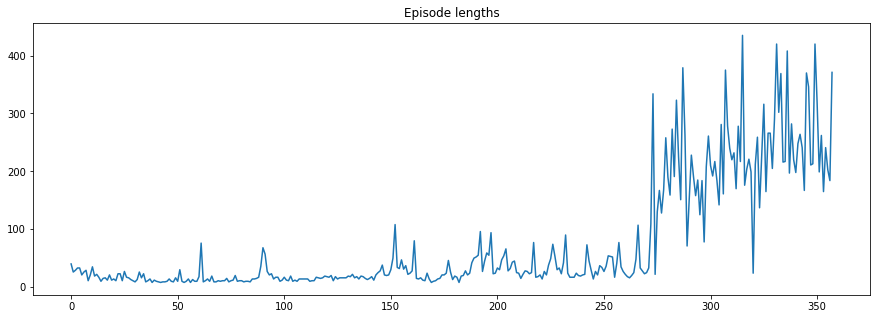

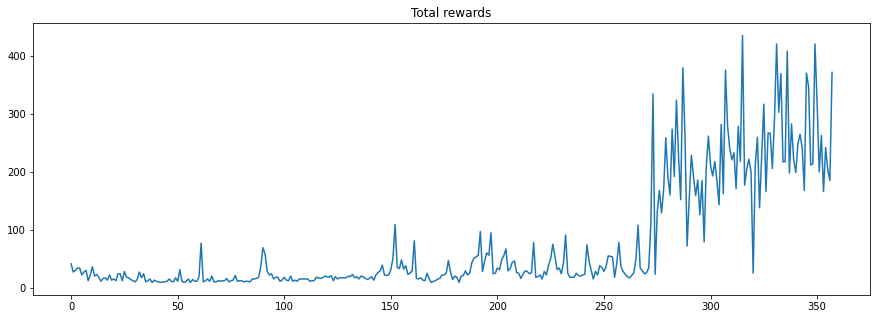

In [17]:
model, episode_lengths, total_rewards = train(
    "CartPole-v1",
    max_episodes=500,
    early_stopping_avg_reward=200,
)

plt.figure(figsize=(15, 5))
plt.plot(episode_lengths)
plt.title("Episode lengths")

plt.figure(figsize=(15, 5))
plt.plot(total_rewards)
plt.title("Total rewards")

/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


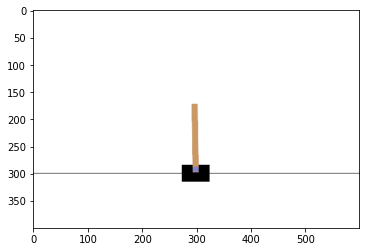

In [22]:
render_model(model, "CartPole-v1")